# Desafio 5 - Maratona Behind the Code 2021

## Bibliotecas

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split

## Configurações

In [2]:
seed = 0
data_path = Path("../desafio/assets/data/")
source_url = "https://github.com/maratonadev/desafio-5-2021/raw/main/assets/data/"

## Dados

### Download

In [3]:
# !mkdir -p {data_path}
# !wget -q -N -P {data_path} {source_url}"dataset.csv"
# !wget -q -N -P {data_path} {source_url}"ANSWERS.csv"
# !ls {data_path}

### Carregamento

In [4]:
df_all = pd.read_csv(data_path / "dataset.csv")
answers = pd.read_csv(data_path / "ANSWERS.csv")

assert list(answers.columns) == list(df_all.columns)
all_cols = list(df_all.columns)
print(all_cols)

['ID', 'GENDER', 'SENIORCITIZEN', 'PARTNER', 'DEPENDENTS', 'TENURE', 'PHONESERVICE', 'MULTIPLELINES', 'INTERNETSERVICE', 'ONLINESECURITY', 'ONLINEBACKUP', 'DEVICEPROTECTION', 'TECHSUPPORT', 'STREAMINGTV', 'STREAMINGMOVIES', 'CONTRACT', 'PAPERLESSBILLING', 'PAYMENTMETHOD', 'MONTHLYCHARGES', 'TOTALCHARGES', 'CHURN']


### Informações gerais

In [5]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4548 entries, 0 to 4547
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                4548 non-null   int64  
 1   GENDER            4520 non-null   object 
 2   SENIORCITIZEN     4523 non-null   float64
 3   PARTNER           4524 non-null   object 
 4   DEPENDENTS        4526 non-null   object 
 5   TENURE            4533 non-null   float64
 6   PHONESERVICE      4520 non-null   object 
 7   MULTIPLELINES     4523 non-null   object 
 8   INTERNETSERVICE   4524 non-null   object 
 9   ONLINESECURITY    4518 non-null   object 
 10  ONLINEBACKUP      4518 non-null   object 
 11  DEVICEPROTECTION  4524 non-null   object 
 12  TECHSUPPORT       4530 non-null   object 
 13  STREAMINGTV       4523 non-null   object 
 14  STREAMINGMOVIES   4523 non-null   object 
 15  CONTRACT          4525 non-null   object 
 16  PAPERLESSBILLING  4517 non-null   object 


- A maioria das variáveis (colunas) parece não ser numérica e precisará ser tratada antes do uso em modelos de machine learning.
- Com exceção da variável que identifica cada cliente (`ID`) e da variável de destino (`CHURN`), todas têm dados faltantes (nulos).

### Divisão dos dados entre treino e teste

Antes de inspecionar os dados, serão reservados alguns exemplos para teste, que não serão vistos durante a análise ou modelagem dos dados:

In [6]:
test_size = 500
target = "CHURN"
df_train, df_test = train_test_split(
    df_all, test_size=test_size, random_state=seed, stratify=df_all[[target]]
)
print(f"Dimensões dos dados de treino: {df_train.shape}")
print(f"Dimensões dos dados de teste: {df_test.shape}")

Dimensões dos dados de treino: (4048, 21)
Dimensões dos dados de teste: (500, 21)


### Variável destino

A variável destino para este desafio é `CHURN`, que indica se o cliente foi perdido ou não. Vamos dar uma olhada em como está a distribuição dessa variável:

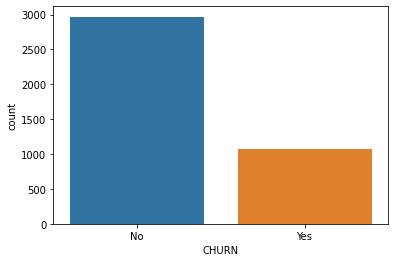

In [7]:
churn_plot = sns.countplot(
    data=df_train, x=target, order=df_train[target].value_counts().index
)
plt.show()

In [8]:
df_train[target].value_counts(normalize=True).rename("Proporção").to_frame()

,Proporção
No,0.733696
Yes,0.266304


- A maioria dos clientes (cerca de 73%) não foi perdido

### Dados de exemplo

In [9]:
with pd.option_context("display.max_columns", None):
    display(df_train.sample(10, random_state=seed))

,ID,GENDER,SENIORCITIZEN,PARTNER,DEPENDENTS,TENURE,PHONESERVICE,MULTIPLELINES,INTERNETSERVICE,ONLINESECURITY,ONLINEBACKUP,DEVICEPROTECTION,TECHSUPPORT,STREAMINGTV,STREAMINGMOVIES,CONTRACT,PAPERLESSBILLING,PAYMENTMETHOD,MONTHLYCHARGES,TOTALCHARGES,CHURN
263,6155,Male,0.0,No,Yes,66.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),34.34,1283.49,No
2533,9074,Male,0.0,No,Yes,1.0,Yes,Yes,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,12.23,12.23,No
490,1780,Female,0.0,Yes,Yes,9.0,Yes,Yes,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,108.93,554.83,No
3655,7462,Female,0.0,No,No,61.0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,NaN,118.86,6437.91,No
2709,4493,Female,0.0,No,No,1.0,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,116.13,116.13,No
2239,8619,Female,0.0,Yes,Yes,64.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Bank transfer (automatic),20.66,1337.51,No
1234,9229,Female,0.0,Yes,Yes,9.0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,32.08,202.83,No
551,5658,Female,1.0,No,No,1.0,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,18.00,18.0,Yes
3594,7884,Female,1.0,No,No,6.0,Yes,No,Fiber optic,Yes,No,No,No,NaN,No,Month-to-month,Yes,Electronic check,205.27,582.07,No
266,4843,Female,0.0,No,No,68.0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Electronic check,1.29,6061.59,No
